In [140]:
import datetime as dt
import json
import os
import re

import lightgbm as lgbm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from dotenv import load_dotenv
from joblib import dump, load
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve

from sqlalchemy import create_engine, text
from sqlalchemy import Column, Integer, Float, String, DateTime, Text
from sqlalchemy.ext.declarative import declarative_base
from sqlalchemy.orm import sessionmaker
from sqlalchemy.dialects.mysql import JSON

In [141]:
OUTPUT_PATH = "output"
MODE = "train"

## 学習データ取得

In [142]:
load_dotenv()
user = os.environ.get('DB_USER')
password = os.environ.get('DB_PASS')
host = os.environ.get('DB_HOST')
port = os.environ.get('DB_PORT')
database = os.environ.get('DB_NAME')
url = f'mysql+mysqlconnector://{user}:{password}@{host}:{port}/{database}'

engine = create_engine(url)

query_races = 'SELECT * FROM races'
query_race_results = 'SELECT * FROM race_results'

with engine.connect() as connection:
    race_df = pd.read_sql_query(sql=text(query_races), con=connection)
    race_results_df = pd.read_sql_query(sql=text(query_race_results), con=connection)

## 特徴量化

In [143]:
def get_race_state_features(df):
    return_df = df.copy()
    return_df["race_course"] = df["race_state"].str[1]
    return_df["race_distance"] = df["race_state"].str.extract(r'芝[左右]?(?: 外)?(\d+)m')[0]
    return_df["race_weather"] = df["race_state"].str.extract(r'天候 : (\w+)')[0]
    return_df["race_state"] = df["race_state"].str.extract(r'芝 : (\w+)')[0]
    return_df["race_start"] =  df["race_state"].str.extract(r'発走 : (\d+:\d+)')[0].str.replace(':', '')
    return return_df

def get_sex_and_age(df):
    return_df = df.copy()
    return_df["sex"] = return_df["sex_and_age"].str[0]
    return_df["age"] = return_df["sex_and_age"].str[1]
    return return_df

def get_horse_weight(df):
    return_df = df.copy()
    return_df["difference_weight"] = return_df["horse_weight"].str[3:].replace(re.compile(r"\(|\)"), "", regex=True)
    return_df["difference_weight"].replace('', pd.NA, inplace=True)
    return_df["difference_weight"] = pd.to_numeric(return_df["difference_weight"], errors='coerce')

    return_df["horse_weight"] = return_df["horse_weight"].str[0:3]
    return return_df

def get_date(df, mode):
    return_df = df.copy()
    return_df['date'] = return_df['date'].str.split(' ', expand=True)[0]
    if mode == "train":
        return_df['date'] = pd.to_datetime(return_df['date'], format='%Y年%m月%d日')
        return_df['day_of_year'] = return_df['date'].dt.day_of_year
    elif mode == "predict":
        return_df['date'] = pd.to_datetime(return_df['date'].str[:-3], format='%m月%d日')
        return_df['day_of_year'] = 2024
    return_df['date_cos'] = np.cos(2 * np.pi * return_df['day_of_year'] / return_df['day_of_year'].max())
    return_df['date_sin'] = np.sin(2 * np.pi * return_df['day_of_year'] / return_df['day_of_year'].max())
    return return_df

In [144]:
def get_all_features(race_df, race_results_df, mode):
    USE_COLUMNS = [
        "id", "race_name", "race_place", "number_of_entries", "race_state", "date",
        "box", "horse_order", "sex_and_age", "burden_weight",
        "jockey", "horse_weight", "horse_trainer", "horse_owner", "odds"
    ]

    if mode == "train":
        merge_df = pd.merge(race_df, race_results_df, on='id', how='left').dropna(subset=["id"])
        USE_COLUMNS.append("rank")
        use_df = merge_df[USE_COLUMNS]
    elif mode == "predict":
        merge_df = pd.merge(race_df, race_results_df, left_on='id', right_on='race_id', how='left').dropna(subset=["id"])
        use_df = merge_df[USE_COLUMNS]
    else:
        raise ValueError("Unsupported mode. Use 'train' or 'predict'.")

    df = use_df.copy()
    df = get_race_state_features(df)
    df = get_sex_and_age(df)
    df = get_horse_weight(df)
    df = get_date(df, mode)
    
    return df

In [145]:
def label_encoder(df, cols, mode, output_path):
    return_df = df.copy()
    return_df[cols] = return_df[cols].fillna('missing')

    oe = preprocessing.OrdinalEncoder(
        handle_unknown="use_encoded_value",
        unknown_value=-1,
    )

    categories_filename = os.path.join(output_path, "categories.joblib")

    if mode == "train":
        return_df[cols] = oe.fit_transform(return_df[cols])
        dump(oe, categories_filename)
    elif mode == "predict":
        loaded_encoder = load(categories_filename)
        return_df[cols] = loaded_encoder.transform(return_df[cols])
    else:
        raise ValueError("Unsupported mode. Use 'train' or 'predict'.")
    return_df = return_df.replace({'nan': np.nan})
    return return_df

In [146]:
def clean_df(df, int_columns, float_columns, mode):
    return_df = df.copy()
    if mode == "train":
        return_df['rank'] = return_df['rank'].replace({'1': 1, '2': 1, '3': 1})
        return_df.loc[~(return_df['rank'] == 1), 'rank'] = 0

    for col in int_columns:
        return_df[col] = pd.to_numeric(return_df[col], errors='coerce').fillna(0).astype('int64')

    for col in float_columns:
        return_df[col] = pd.to_numeric(return_df[col], errors='coerce')
    return return_df

In [147]:
def preprocess_data(df, mode, output_path):
    ENCODING_COLUMNS = [
        "race_name", "race_place",
        "race_state", "race_course", "race_weather",
        "sex_and_age", "sex",
        "jockey", "horse_trainer", "horse_owner"
    ]
    
    INT_COLUMNS = [
        "id", "box", "horse_order", "horse_weight", "race_distance",
        "race_start", "age", "day_of_year", "number_of_entries",
        "difference_weight", "day_of_year", "odds"
    ]
    if mode == "train":
        INT_COLUMNS.append("rank")
    
    FLOAT_COLUMNS =[
        "burden_weight"
    ]
    
    encoded_df = label_encoder(df, ENCODING_COLUMNS, mode, output_path)
    
    cleaned_df = clean_df(encoded_df, INT_COLUMNS, FLOAT_COLUMNS, mode)
    
    return cleaned_df

In [148]:
feature_engineered_df = get_all_features(race_df, race_results_df, MODE)
preprocessed_df = preprocess_data(feature_engineered_df, MODE, OUTPUT_PATH)

## 学習結果保存

In [149]:
def refund(race_id, horse_order, bet):
    refund_amount = 0

    try:
        query = f"SELECT * FROM refund WHERE race_id = '{race_id}'"
        with engine.connect() as connection:
            refund_df = pd.read_sql_query(sql=text(query), con=connection)

        if refund_df.empty:
            raise ValueError("The query result is empty. No data found.")
    except Exception as e:
        print(f"An error occurred: {e}")
        return 0, [], []

    matching_rows = refund_df[refund_df['winning_horse_order'] == horse_order]
    payout = 0
    if not matching_rows.empty:
        payout += matching_rows['payout'].values[0]

    refund_amount += payout * (bet / 100)
    return int(refund_amount), not matching_rows.empty, refund_df['winning_horse_order'].tolist(), refund_df['payout'].tolist()

def simulate_betting(race_horse_pairs, fold, output_path, bet_amount=100):
    total_refund = 0
    total_bet = 0
    total_hits = 0
    race_ids = []
    balances = []

    for race_id, horse_order in race_horse_pairs:
        refund_amount, is_hit, winning_orders, payouts = refund(race_id, horse_order, bet_amount)
        total_refund += refund_amount
        total_bet += bet_amount
        if is_hit:
            total_hits += 1
        race_ids.append(str(race_id))
        balances.append(total_refund - total_bet)
        # print(f"Race ID: {race_id}, Horse Order: {horse_order}, Refund: {refund_amount}, Is Hit: {is_hit}, Winning Orders: {winning_orders}, Payouts: {payouts}")

    # 回収率と的中率の計算
    recovery_rate = (total_refund / total_bet) * 100 if total_bet > 0 else 0
    hit_rate = (total_hits / len(race_horse_pairs)) * 100 if race_horse_pairs else 0
    print(f"Total refund amount: {total_refund}")
    print(f"Total bet amount: {total_bet}")
    print(f"Recovery Rate: {recovery_rate:.2f}%")
    print(f"Hit Rate: {hit_rate:.2f}%")

    # グラフの作成と保存
    plt.figure(figsize=(10, 5))
    plt.plot(race_ids, balances, marker='o', label='Profit/Loss', color='b')
    plt.title('Betting Simulation')
    plt.xlabel('Race ID')
    plt.ylabel('Amount ($)')
    # plt.xticks(ticks=[i for i in range(len(race_ids)) if i % 100 == 0], labels=[race_ids[i] for i in range(len(race_ids)) if i % 100 == 0])
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.legend()
    bcor_filename = os.path.join(output_path, f"{fold}_simulation.png")
    plt.savefig(bcor_filename)
    plt.show()
    plt.close()

    return recovery_rate, hit_rate

In [150]:
def evaluate_model_performance(model, X_test, y_test, version, output_dir):
    y_pred = model.predict_proba(X_test)[:, 1]
    y_pred_binary = model.predict(X_test)
    
    auc_score = roc_auc_score(y_test, y_pred)
    print(f'Test AUC Score: {auc_score}')
    
    cm = confusion_matrix(y_test, y_pred_binary)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.xlabel('Predicted')
    plt.ylabel('True')
    cm_filename = os.path.join(output_dir, f"{version}_confusion_matrix.png")
    plt.savefig(cm_filename)
    plt.close()

    fpr, tpr, _ = roc_curve(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    rc_filename = os.path.join(output_dir, f"{version}_roc_curve.png")
    plt.savefig(rc_filename)
    plt.close()

    feature_importances = pd.DataFrame(model.feature_importances_,
                                        index = X_test.columns,
                                        columns=['importance']).sort_values('importance', ascending=False)
    print(feature_importances)

    lgbm.plot_importance(model, importance_type='split', max_num_features=10)
    plt.title('Feature Importance')
    fi_filename = os.path.join(output_dir, f"{version}_feature_importance.png")
    plt.savefig(fi_filename)
    plt.close()

    X_test["predict_proba"] = y_pred

    # predict_probaが0.5以上のデータに絞り込む
    filtered_df = X_test[X_test['predict_proba'] >= 0.5]
    # filtered_df = filtered_df[filtered_df['odds'] >= 2]

    # レースごとの一番複勝の確率が高い馬にベットする
    # 絞り込んだデータの中で各race_idごとにpredict_probaが最大の行を取得
    if not filtered_df.empty:
        idx = filtered_df.groupby('id')['predict_proba'].idxmax()
    else:
        return {}

    result_df = X_test.loc[idx]
    race_horse_pairs = [(int(row['id']), int(row['horse_order'])) for _, row in result_df.iterrows()]
    recovery_rate, hit_rate = simulate_betting(race_horse_pairs, version, output_dir, 100)

    evaluation_results = {
        'importances': feature_importances, 
        'AUC': auc_score,
        'TP': int(cm[1][1]),
        'FP': int(cm[0][1]),
        'FN': int(cm[1][0]),
        'TN': int(cm[0][0]),
        'FPR': fpr, 
        'TPR': tpr,
        'recovery_rate': recovery_rate,
        'hit_rate': hit_rate,
        'memo': 'memo',
        'version': version,
    }

    return evaluation_results

In [151]:
Base = declarative_base()

class ModelEvaluation(Base):
    __tablename__ = 'model_evaluation'
    
    id = Column(Integer, primary_key=True)
    feature_importance_json = Column(JSON)
    TP = Column(Integer)
    FP = Column(Integer)
    FN = Column(Integer)
    TN = Column(Integer)
    FPR = Column(JSON)
    TPR = Column(JSON)
    AUC = Column(Float)
    memo = Column(Text)
    version = Column(String(255))
    created_date = Column(DateTime, default=dt.datetime.utcnow)

def save_evaluation(evaluation_results, engine):
    Base.metadata.create_all(engine)
    
    Session = sessionmaker(bind=engine)
    session = Session()

    new_evaluation = ModelEvaluation(
        feature_importance_json=evaluation_results["importances"].to_json(),
        TP=evaluation_results["TP"],
        FP=evaluation_results["FP"],
        FN=evaluation_results["FN"],
        TN=evaluation_results["TN"],
        FPR=json.dumps(evaluation_results["FPR"].tolist()),
        TPR=json.dumps(evaluation_results["TPR"].tolist()),
        AUC=evaluation_results["AUC"],
        memo=evaluation_results["memo"],
        version=evaluation_results["version"],
        created_date=dt.datetime.utcnow()
    )
    
    session.add(new_evaluation)
    session.commit()
    session.close()

C:\Users\katsuyaSuzuki\AppData\Local\Temp\ipykernel_16804\2695455613.py:1: MovedIn20Warning: The ``declarative_base()`` function is now available as sqlalchemy.orm.declarative_base(). (deprecated since: 2.0) (Background on SQLAlchemy 2.0 at: https://sqlalche.me/e/b8d9)
  Base = declarative_base()


## 検証

fold_0---------------------
Training until validation scores don't improve for 100 rounds
[10]	training's auc: 0.846187	valid_1's auc: 0.822521
[20]	training's auc: 0.852902	valid_1's auc: 0.822661
[30]	training's auc: 0.860966	valid_1's auc: 0.821385
[40]	training's auc: 0.868706	valid_1's auc: 0.822015
[50]	training's auc: 0.875466	valid_1's auc: 0.821273
[60]	training's auc: 0.880978	valid_1's auc: 0.820629
[70]	training's auc: 0.88708	valid_1's auc: 0.820315
[80]	training's auc: 0.893164	valid_1's auc: 0.819417
[90]	training's auc: 0.898798	valid_1's auc: 0.818936
[100]	training's auc: 0.904855	valid_1's auc: 0.818516
[110]	training's auc: 0.910397	valid_1's auc: 0.817759
Early stopping, best iteration is:
[13]	training's auc: 0.848187	valid_1's auc: 0.823086
Test AUC Score: 0.8203535861585465
                   importance
odds                      123
horse_weight               27
jockey                     26
horse_owner                25
race_start                 23
number_of_e

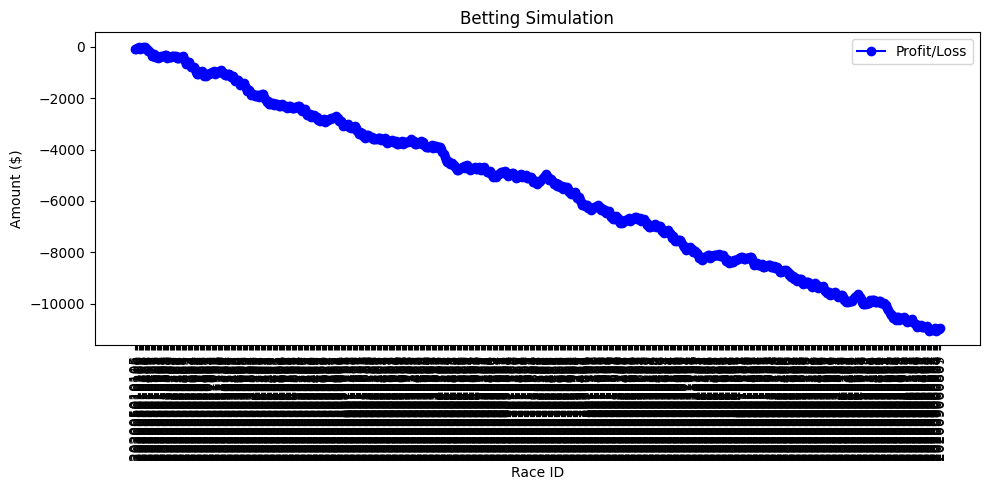

fold_1---------------------
Training until validation scores don't improve for 100 rounds
[10]	training's auc: 0.83978	valid_1's auc: 0.821816
[20]	training's auc: 0.845449	valid_1's auc: 0.821535
[30]	training's auc: 0.850442	valid_1's auc: 0.821381
[40]	training's auc: 0.855317	valid_1's auc: 0.820979
[50]	training's auc: 0.860202	valid_1's auc: 0.820398
[60]	training's auc: 0.865143	valid_1's auc: 0.820208
[70]	training's auc: 0.869518	valid_1's auc: 0.819889
[80]	training's auc: 0.874346	valid_1's auc: 0.82006
[90]	training's auc: 0.878846	valid_1's auc: 0.819746
[100]	training's auc: 0.883079	valid_1's auc: 0.81948
Early stopping, best iteration is:
[7]	training's auc: 0.838388	valid_1's auc: 0.822009
Test AUC Score: 0.8249102366545145
                   importance
odds                       76
number_of_entries          20
horse_trainer              13
horse_order                11
horse_owner                10
horse_weight               10
date_sin                    9
race_star

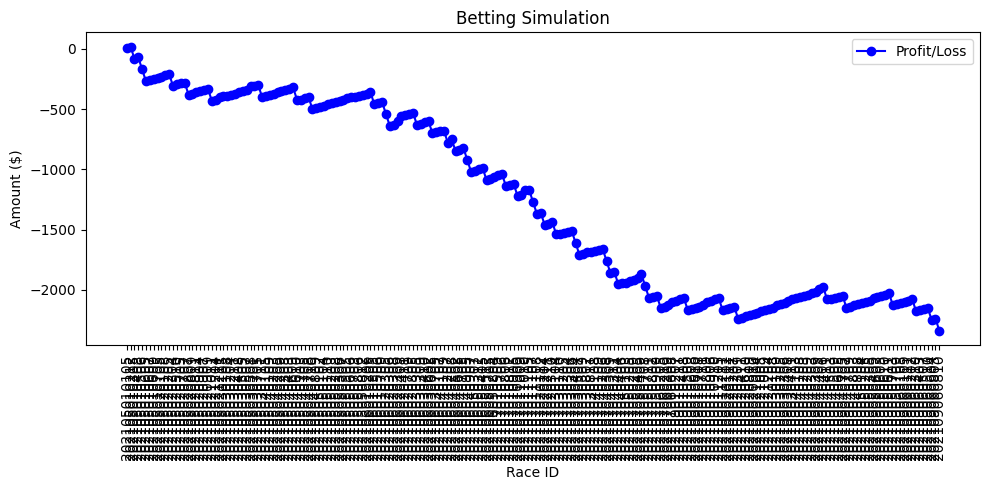

fold_2---------------------
Training until validation scores don't improve for 100 rounds
[10]	training's auc: 0.836303	valid_1's auc: 0.825887
[20]	training's auc: 0.839813	valid_1's auc: 0.826798
[30]	training's auc: 0.844236	valid_1's auc: 0.826627
[40]	training's auc: 0.848858	valid_1's auc: 0.825881
[50]	training's auc: 0.853384	valid_1's auc: 0.825875
[60]	training's auc: 0.856894	valid_1's auc: 0.824861
[70]	training's auc: 0.860581	valid_1's auc: 0.824783
[80]	training's auc: 0.86471	valid_1's auc: 0.824064
[90]	training's auc: 0.868261	valid_1's auc: 0.823762
[100]	training's auc: 0.872154	valid_1's auc: 0.822707
[110]	training's auc: 0.87573	valid_1's auc: 0.822399
Early stopping, best iteration is:
[16]	training's auc: 0.838604	valid_1's auc: 0.826904
Test AUC Score: 0.8323305623940584
                   importance
odds                      150
number_of_entries          43
horse_weight               39
horse_owner                27
horse_trainer              27
race_start  

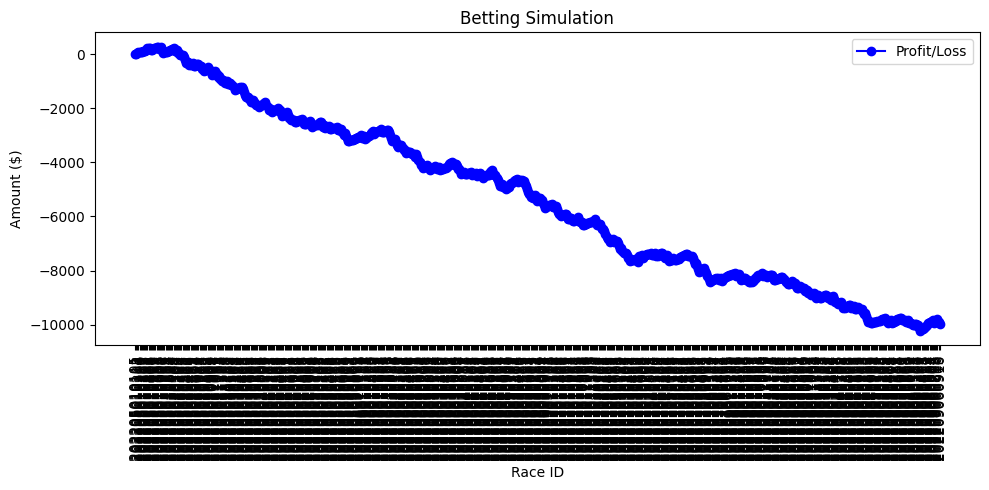

fold_3---------------------
Training until validation scores don't improve for 100 rounds
[10]	training's auc: 0.834836	valid_1's auc: 0.832836
[20]	training's auc: 0.837504	valid_1's auc: 0.832593
[30]	training's auc: 0.841111	valid_1's auc: 0.832763
[40]	training's auc: 0.845223	valid_1's auc: 0.832637
[50]	training's auc: 0.849292	valid_1's auc: 0.832642
[60]	training's auc: 0.852059	valid_1's auc: 0.832329
[70]	training's auc: 0.855353	valid_1's auc: 0.832106
[80]	training's auc: 0.859016	valid_1's auc: 0.831553
[90]	training's auc: 0.862244	valid_1's auc: 0.831263
[100]	training's auc: 0.865328	valid_1's auc: 0.830643
[110]	training's auc: 0.868505	valid_1's auc: 0.830283
[120]	training's auc: 0.871047	valid_1's auc: 0.830277
[130]	training's auc: 0.873899	valid_1's auc: 0.829892
Early stopping, best iteration is:
[38]	training's auc: 0.844237	valid_1's auc: 0.832846
Test AUC Score: 0.8355269717408152
                   importance
odds                      280
horse_weight        

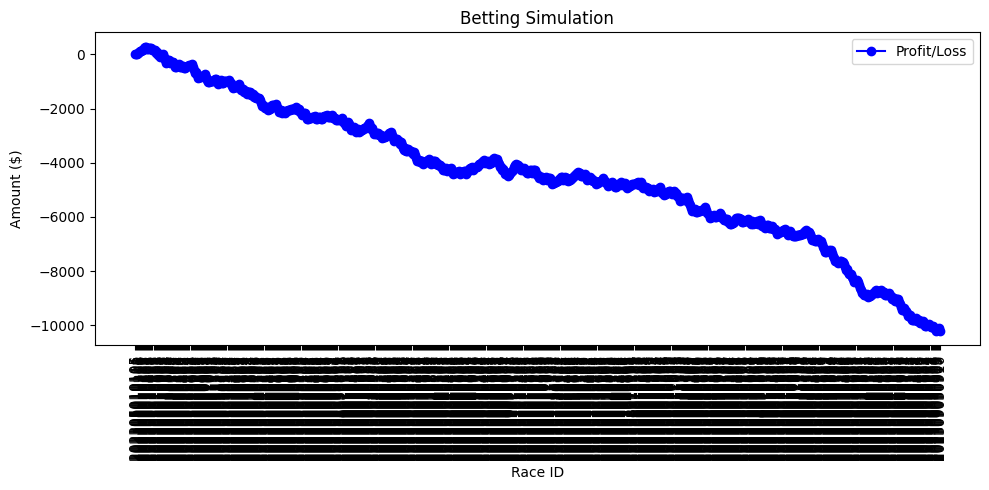

fold_4---------------------
Training until validation scores don't improve for 100 rounds
[10]	training's auc: 0.834385	valid_1's auc: 0.836215
[20]	training's auc: 0.837302	valid_1's auc: 0.836064
[30]	training's auc: 0.840281	valid_1's auc: 0.835629
[40]	training's auc: 0.843632	valid_1's auc: 0.835063
[50]	training's auc: 0.846604	valid_1's auc: 0.835079
[60]	training's auc: 0.849485	valid_1's auc: 0.835004
[70]	training's auc: 0.85216	valid_1's auc: 0.835011
[80]	training's auc: 0.854862	valid_1's auc: 0.834629
[90]	training's auc: 0.857582	valid_1's auc: 0.834418
[100]	training's auc: 0.860361	valid_1's auc: 0.834187
[110]	training's auc: 0.862981	valid_1's auc: 0.833908
Early stopping, best iteration is:
[14]	training's auc: 0.83543	valid_1's auc: 0.836457
Test AUC Score: 0.8339560686587775
                   importance
odds                      149
number_of_entries          43
horse_owner                27
horse_weight               27
horse_trainer              19
date_cos    

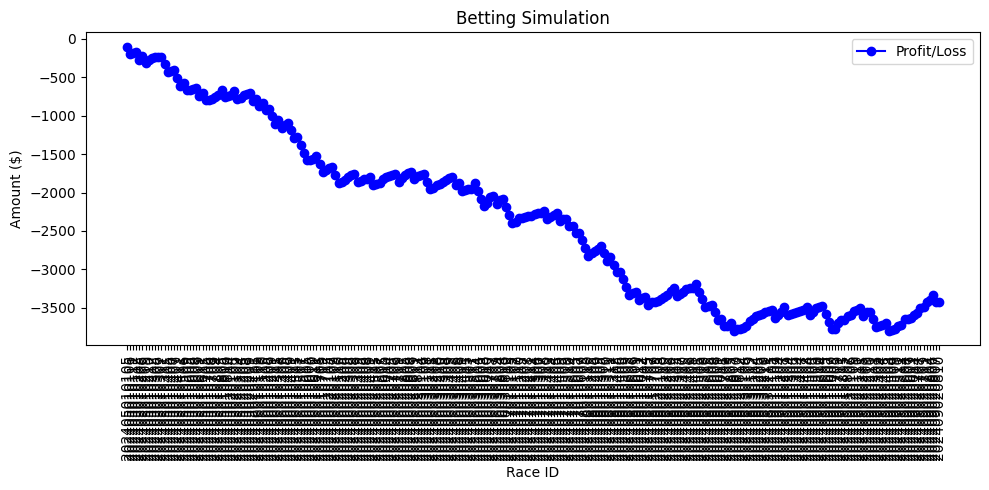

In [152]:
train_dates = [dt.datetime(2018, 12, 31), dt.datetime(2019, 12, 31), dt.datetime(2020, 12, 31), dt.datetime(2021, 12, 31), dt.datetime(2022, 12, 31)]
val_dates = [dt.datetime(2019, 12, 31), dt.datetime(2020, 12, 31), dt.datetime(2021, 12, 31), dt.datetime(2022, 12, 31), dt.datetime(2023, 12, 31)]
test_dates = [dt.datetime(2020, 12, 31), dt.datetime(2021, 12, 31), dt.datetime(2022, 12, 31), dt.datetime(2023, 12, 31), dt.datetime(2024, 12, 31)]

def split_df(df, train_date, val_date, test_date):
    return_df = df.copy()
    train_df = return_df[return_df['date'] < train_date].drop('date', axis=1)
    val_df = return_df[(return_df['date'] > train_date) & (return_df['date'] < val_date)].drop('date', axis=1)
    test_df = return_df[(return_df['date'] > val_date) & (return_df['date'] < test_date)].drop('date', axis=1)
    return train_df, val_df, test_df

def split_target(df):
    return_df = df.copy()
    X = return_df.drop('rank', axis=1)
    y = return_df['rank']
    return X, y

for i in range(5):
    print(f"fold_{i}---------------------")
    train_df, val_df, test_df = split_df(preprocessed_df, train_dates[i], val_dates[i], test_dates[i])

    X_train, y_train = split_target(train_df)
    X_val, y_val = split_target(val_df)
    X_test, y_test = split_target(test_df)

    train_set = lgbm.Dataset(X_train, y_train)
    val_set = lgbm.Dataset(X_val, y_val)

    params = {
        "objective": "binary",
        "metric": "auc",
        'boosting_type': 'gbdt',
        'n_estimators': 10000,
        'random_state': 74,
    }

    clf = lgbm.LGBMClassifier(**params)

    clf.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_val, y_val)],
            callbacks=[lgbm.early_stopping(stopping_rounds=100, verbose=True), lgbm.log_evaluation(10)])
    
    evaluation_results = evaluate_model_performance(clf, X_test, y_test, str(i), OUTPUT_PATH)
    # save_evaluation(evaluation_results, engine)

## 全てのデータで学習

In [153]:
X_train, y_train = split_target(preprocessed_df.drop('date', axis=1))

train_set = lgbm.Dataset(X_train, y_train)

params = {
    "objective": "binary",
    "metric": "auc",
    'boosting_type': 'gbdt',
    'n_estimators': 120,
    'random_state': 74,
}

clf = lgbm.LGBMClassifier(**params)

clf.fit(X_train, y_train)

LGBMClassifier(metric='auc', n_estimators=120, objective='binary',
               random_state=74)

In [154]:
model_filename = os.path.join(OUTPUT_PATH, "model.joblib")
dump(clf, model_filename)

['output\\model.joblib']

## 学習：2023年、テスト：2024年でのテスト
※n_estimatorsの設定に注意

Test AUC Score: 0.8326289760593458
                   importance
odds                      398
horse_weight              208
horse_owner               197
horse_trainer             176
jockey                    145
id                        144
number_of_entries         140
day_of_year               124
race_start                123
date_sin                   98
race_name                  95
date_cos                   91
horse_order                86
difference_weight          85
sex_and_age                46
race_distance              43
burden_weight              39
box                        38
race_state                 32
race_weather               29
age                        27
race_place                 26
race_course                10
sex                         0
Total refund amount: 22660
Total bet amount: 27300
Recovery Rate: 83.00%
Hit Rate: 65.93%


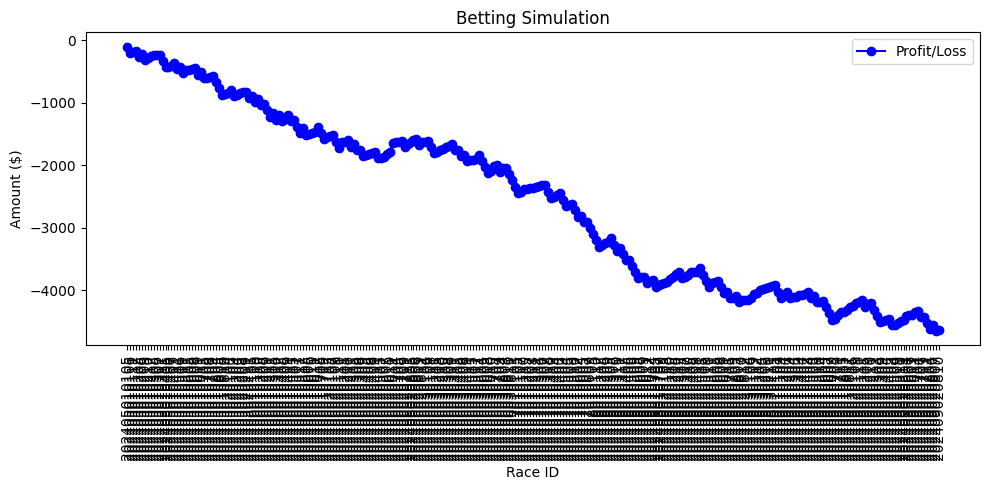

In [155]:
train_df = preprocessed_df[preprocessed_df['date'] < dt.datetime(2023, 12, 31)].drop('date', axis=1)
test_df = preprocessed_df[preprocessed_df['date'] > dt.datetime(2024, 1, 1)].drop('date', axis=1)

X_train, y_train = split_target(train_df)
X_test, y_test = split_target(test_df)

train_set = lgbm.Dataset(X_train, y_train)

params = {
    "objective": "binary",
    "metric": "auc",
    'boosting_type': 'gbdt',
    'n_estimators': 80,
    'random_state': 74,
}

clf = lgbm.LGBMClassifier(**params)

clf.fit(X_train, y_train)

evaluation_results = evaluate_model_performance(clf, X_test, y_test, "test2024", OUTPUT_PATH)